# Imports

In [ ]:
# !pip install yfinance

In [1]:
import os
from functools import partial
from datetime import datetime

import numpy as np
import pandas as pd

import utils
import pipelines
import processing

C:\Users\dstan\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Pipeline runs

## Import tickers from given custom list

In [19]:
# filename = 'data/selected_spreads.csv'
# ticker_pairs = pd.read_csv(filename, header=0)
# ticker_pairs.set_index('spreads', inplace=True)

# separated_indexes = separate_pair_index(ticker_pairs.index)
# ticker_pairs['x'] = separated_indexes['x']
# ticker_pairs['y'] = separated_indexes['y']

# ticker_pairs = ticker_pairs.loc[~ticker_pairs.index.str.contains(r'CIT|LORL|ENBL|MDP')]

# ticker_list = set(list(ticker_pairs['x']) + list(ticker_pairs['y']))

# Get stock data from selected industries only
# stonks = get_stonk_data_by_industry('2017-04-20', '2022-04-18', industries=[])

# failed_list = '|'.join(['SITE', 'INFO', 'RRD', 'HWM', 'OR', 'NGVT', 'VRS', 'TWLO', 'NUAN', 'PI', 'RRR', 'TPB', 'USFD', 'GMS', 'ENIC'])
# ticker_pairs = ticker_pairs[~ticker_pairs.index.str.contains(failed_list)]
# X = stonks.loc[ticker_pairs['x']]
# Y = stonks.loc[ticker_pairs['y']]

## Download stock daily prices

In [46]:
# Gets all ticker names (no argument given)
ticker_list = utils.get_tickers_by_industry(market_cap_min_mm=1000, market_cap_max_mm=None, industries=[])

In [57]:
# Specific date - 3rd of March 2022 (Y, M, D)
# date_to = datetime(2022, 3, 1)
# Date of today
date_to = datetime.today()
# How many years' of data to download (going backwards from date_end). Year can be a floating point number
period_years = 5

In [58]:
# Download ticker price data for the tickers selected above (saved to .csv automatically)
df, df_clean = utils.download_stonk_prices(ticker_list.index, period_years=period_years, date_to=date_to)

[*********************100%***********************]  2815 of 2815 completed

10 Failed downloads:
- PFE.WI: No data found, symbol may be delisted
- BIP.PRA: No data found, symbol may be delisted
- O.WI: No data found, symbol may be delisted
- POST WI: No data found, symbol may be delisted
- BIP.PRB: No data found, symbol may be delisted
- SNX.WI: No data found, symbol may be delisted
- MRK.WI: No data found, symbol may be delisted
- T WD: No data found, symbol may be delisted
- RXN WI: No data found, symbol may be delisted
- DELL WI: No data found, symbol may be delisted


In [47]:
ticker_list.groupby('subindustry').count()

,market_cap
subindustry,
automobiles_and_components,42
banks,177
capital_goods,231
chemicals,61
commercial_and_professional_services,72
construction_materials,7
consumer_durables_and_apparel,73
consumer_services,99
consumer_staples,121


In [3]:
# Visos industrijos:
# industries = ticker_list['subindustry'].unique()
# Jei nori atskirai po kelias arba po viena (uncomment):
industries = ['consumer_services']
l_reg = 3
l_roll = 2
dt = 10
date_from = '2017-04-20'
date_to = '2022-04-18'

output_dir = 'data'

In [4]:
i = 1
total_industries = len(industries)
for industry in industries:
    stonks = utils.get_stonk_data_by_industry(date_from, date_to, industries=[industry])
    X, Y = processing.combine_stonk_pairs(stonks)
    
    print('Industry ({0}/{1}): {2}'.format(i, total_industries, industry))
    
    print('Processing residuals...')
    residuals, betas, _ = utils.measure_time(partial(processing.get_rolling_residuals, X=X, Y=Y, l_reg=l_reg, l_roll=l_roll, dt=dt))
    std_residuals, _, _ = processing.get_standardized_residuals(residuals)
    trades_before = len(std_residuals)
    std_residuals = std_residuals[std_residuals.iloc[:, -1].abs() >= 2]
    trades_after = len(std_residuals)
    print('{0} trades selected out of {1} by residual values'.format(trades_after, trades_before))
    if trades_after == 0:
        print('No trades left after filtering residuals, skipping this industry...')
        continue
    residuals = residuals.loc[std_residuals.index]
    betas = betas.loc[std_residuals.index]
    
    print('Processing ADFs...')
    adfs, adfs_raw = utils.measure_time(partial(processing.get_aggregate_adfs, residuals, betas=betas))
    
    selected_by_adf = (adfs >= 0.5).values
    trades_before = len(std_residuals)
    std_residuals = std_residuals[selected_by_adf]
    trades_after = len(std_residuals)
    print('{0} trades selected out of {1} by ADF pass rates'.format(trades_after, trades_before))
    
    if len(std_residuals) == 0:
        print('No trades left after filtering ADF pass rates, skipping this industry...')
        continue

    residuals_max_mean = processing.get_mean_residual_magnitude(std_residuals, dt=21)
    print('Mean max residual value for {0} after filtering is {1}'.format(industry, residuals_max_mean))

    betas = betas.loc[std_residuals.index]
    residuals = residuals.loc[std_residuals.index]
    adfs_raw = adfs_raw.loc[std_residuals.index]
    
    print('Writing results to CSV...')
    residuals.to_csv(os.path.join(output_dir, industry + '_residuals.csv'), header=False, index=True)
    betas.to_csv(os.path.join(output_dir, industry + '_betas.csv'), header=False, index=True)
    adfs_raw.to_csv(os.path.join(output_dir, industry + '_adfs_raw.csv'), header=False, index=True)
    adfs.to_csv(os.path.join(output_dir, industry + '_adfs.csv'), header=False, index=True)
    i+= 1
    
print('*** All done ***')

Industry (1/1): consumer_services
Processing residuals...
Done after: 12s
355 trades selected out of 2485 by residual values
Processing ADFs...
Done after: 38s
67 trades selected out of 355 by ADF pass rates
Mean max residual value for consumer_services after filtering is 3.9800000190734863
Writing results to CSV...
*** All done ***


# Data analysis

In [119]:
# more = pd.read_csv('data/temp/consumer_services_adfs_raw.csv', header=None)
# less = pd.read_csv('data/consumer_services_adfs_raw.csv', header=None)

# trades_more = pd.Series(more[0].unique())
# trades_less = pd.Series(less[0].unique())

# more_in_less = trades_more[trades_more.isin(trades_less)]
# less_in_more = trades_less[trades_less.isin(trades_more)]

# len(more_in_less) / len(trades_more)
# len(less_in_more) / len(trades_less)

# more_in_less = trades_more[~trades_more.isin(trades_less)]
# less_in_more = trades_less[~trades_less.isin(trades_more)]

In [ ]:
stonks = get_stonk_data_by_industry('2017-04-20', '2022-04-18', industries=[])

In [ ]:
ticker_list = get_tickers_by_industry(market_cap_min_mm=1000, market_cap_max_mm=None, industries=[])

In [ ]:
data_collection_rolling_pipeline(stonks, industries=list(ticker_list['subindustry'].unique()), l_reg=3, l_roll=1, dt=20, market_cap_min_mm=1000, adf_pval_cutoff=0.1, adf_pass_rate_filter=0.5, trade_length_months=3, trading_interval_weeks=2)

In [54]:
df.to_csv('data/eda.csv', index=False, header=True)

<AxesSubplot:>

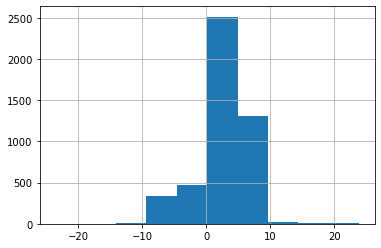

In [25]:
df[df['last_residual'].abs() > 4]['residual_one_month'].hist()

In [41]:
df['residual_diff'] = df['residual_mean_max'] - df['last_residual'].abs()

In [40]:
df[df['last_residual'].abs() > 5][['return_one_month', 'return_two_month', 'return_three_month']].mean()

return_one_month     -0.000979
return_two_month      0.060180
return_three_month    0.030309
dtype: float64

In [39]:
df[df['last_residual'].abs() > 5][['subindustry', 'return_one_month', 'return_two_month', 'return_three_month']].groupby('subindustry').mean()

,return_one_month,return_two_month,return_three_month
subindustry,,,
automobiles_and_components,0.020000,0.040000,0.040000
banks,-0.010714,-0.022143,-0.007857
capital_goods,0.006512,0.009535,-0.021395
chemicals,0.040000,0.035000,0.055000
commercial_and_professional_services,0.010000,0.000000,-0.040000
consumer_services,-0.040000,-0.030000,-0.025000
consumer_staples,-0.010000,-0.020000,-0.030000
diversified_financials,0.003455,0.000182,-0.005818
energy,-0.008235,0.065294,-0.012353


In [ ]:
df[['subindustry', 'return_one_month']].groupby('subindustry').mean()

In [44]:
pd.set_option('display.max_rows', 100)

In [26]:
df

,ticker_x,ticker_y,trade_date,adf_pass_rate,last_residual,beta,intercept,residual_mean_max,return_one_month,residual_one_month,return_two_month,residual_two_month,return_three_month,residual_three_month,data_window_start,subindustry
0,ABC,AMED,2021-10-06,0.54,-2.93,2.93,-83.26,3.74,0.01,-2.838965,-0.01,-3.040186,-0.07,-3.736888,2017-11-14,health_care_equipment_and_services
1,ABC,CAH,2021-10-06,0.92,-2.21,0.29,21.61,3.74,-0.03,-2.959616,-0.02,-2.739765,0.01,-2.038398,2017-11-14,health_care_equipment_and_services
2,ABC,PHG,2021-10-06,0.69,-2.27,0.33,14.11,3.74,0.01,-2.062742,-0.11,-4.361172,-0.14,-4.842980,2017-11-14,health_care_equipment_and_services
3,ABMD,AMEH,2021-10-06,0.54,2.70,0.14,-12.49,3.74,0.12,1.808040,0.04,2.441285,0.18,1.347642,2017-11-14,health_care_equipment_and_services
4,ABT,ADUS,2021-10-06,0.54,-2.47,0.60,31.22,3.74,0.13,-0.707720,0.04,-1.991751,0.02,-2.221983,2017-11-14,health_care_equipment_and_services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100472,KFY,RHI,2021-06-14,0.85,2.34,0.85,22.70,3.05,0.03,1.364591,-0.07,4.573430,-0.04,3.816241,2017-07-24,commercial_and_professional_services
100473,LDOS,RELX,2021-06-14,0.92,2.01,0.10,13.48,3.05,-0.04,3.270891,-0.11,5.556032,-0.11,5.594028,2017-07-24,commercial_and_professional_services
100474,NLSN,RHI,2021-06-14,0.54,2.81,1.78,22.55,3.05,0.00,2.771807,-0.12,4.897370,-0.16,5.607962,2017-07-24,commercial_and_professional_services
100475,VRSK,WCN,2021-06-14,0.77,3.62,0.37,34.24,3.05,0.02,3.126240,0.01,3.386326,0.01,3.252804,2017-07-24,commercial_and_professional_services


In [94]:
def assign_labels(df):
    def label_one_example(example):
        success_one_month = example['return_one_month'] >= 0.035 and (np.abs(example['last_residual']) - np.abs(example['residual_one_month'])) >= 1
        success_two_month = example['return_two_month'] >= 0.065 and (np.abs(example['last_residual']) - np.abs(example['residual_two_month'])) >= 2
        success_three_month = example['return_three_month'] >= 0.095 and (np.abs(example['last_residual']) - np.abs(example['residual_three_month'])) >= 2
        return int(any([success_one_month, success_two_month, success_three_month]))
    df_copy = df.copy()
    df_copy['label'] = df_copy.apply(label_one_example, axis=1)
    return df_copy

In [95]:
def transform_features(df):
    def industry_mappings(example):
        mappings = {
            'chemicals':'materials',
            'construction_materials':'materials',
            'containers_and_packaging':'materials',
            'metals_and_mining':'materials',
            'paper_and_forest_products':'materials',
            #
            'capital_goods':'industrials',
            'commercial_and_professional_services':'industrials',
            'transportation':'industrials',
            #
            'automobiles_and_components':'consumer_discretionary',
            'consumer_durables_and_apparel':'consumer_discretionary',
            'consumer_services':'consumer_discretionary',
            'retailing':'consumer_discretionary',
            #
            'health_care_equipment_and_services':'health_care',
            'pharmaceuticals_biotechnology_and_life_sciences':'health_care',
            #
            'banks':'financials',
            'diversified_financials':'financials',
            'insurance':'financials',
            #
            'software_and_services':'information_technology',
            'technology_hardware_and_equipment':'information_technology',
            'semiconductors_and_semiconductor_equipment':'information_technology',
            #
            'telecommunication_services':'communication_services',
            'media_and_entertainment':'communication_services',
            #
            'energy':'energy',
            'utilities':'utilities',
            'real_estate':'real_estate',
            'consumer_staples':'consumer_staples'
        }
        return mappings[example['subindustry']]
    
    df_copy = df.copy()
    # Select features
    df_copy = df_copy[['adf_pass_rate', 'last_residual', 'residual_mean_max', 'label', 'subindustry']]
    
    # Industry transform
    df_copy.loc[:, 'industry'] = df_copy.apply(industry_mappings, axis=1)
    df_copy = df_copy.drop(columns='subindustry')
    df_copy['industry'] = df_copy['industry'].astype('category')
    
    # Residual transform
    df_copy.loc[:, 'last_residual'] = df_copy['last_residual'].abs()
    
    return df_copy

In [96]:
df = pd.read_csv('data/eda.csv')

In [97]:
df = df[df['beta'] > 0]

In [98]:
df = assign_labels(df)

In [99]:
df = transform_features(df)

In [100]:
df

,adf_pass_rate,last_residual,residual_mean_max,label,industry
0,0.54,2.93,3.74,0,health_care
1,0.92,2.21,3.74,0,health_care
2,0.69,2.27,3.74,0,health_care
3,0.54,2.70,3.74,0,health_care
4,0.54,2.47,3.74,1,health_care
...,...,...,...,...,...
100472,0.85,2.34,3.05,0,industrials
100473,0.92,2.01,3.05,0,industrials
100474,0.54,2.81,3.05,0,industrials
100475,0.77,3.62,3.05,0,industrials


In [48]:
df

,ticker_x,ticker_y,trade_date,adf_pass_rate,last_residual,beta,intercept,residual_mean_max,return_one_month,residual_one_month,return_two_month,residual_two_month,return_three_month,residual_three_month,data_window_start,subindustry,label
0,ABC,AMED,2021-10-06,0.54,-2.93,2.93,-83.26,3.74,0.01,-2.838965,-0.01,-3.040186,-0.07,-3.736888,2017-11-14,health_care_equipment_and_services,0
1,ABC,CAH,2021-10-06,0.92,-2.21,0.29,21.61,3.74,-0.03,-2.959616,-0.02,-2.739765,0.01,-2.038398,2017-11-14,health_care_equipment_and_services,0
2,ABC,PHG,2021-10-06,0.69,-2.27,0.33,14.11,3.74,0.01,-2.062742,-0.11,-4.361172,-0.14,-4.842980,2017-11-14,health_care_equipment_and_services,0
3,ABMD,AMEH,2021-10-06,0.54,2.70,0.14,-12.49,3.74,0.12,1.808040,0.04,2.441285,0.18,1.347642,2017-11-14,health_care_equipment_and_services,0
4,ABT,ADUS,2021-10-06,0.54,-2.47,0.60,31.22,3.74,0.13,-0.707720,0.04,-1.991751,0.02,-2.221983,2017-11-14,health_care_equipment_and_services,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100472,KFY,RHI,2021-06-14,0.85,2.34,0.85,22.70,3.05,0.03,1.364591,-0.07,4.573430,-0.04,3.816241,2017-07-24,commercial_and_professional_services,0
100473,LDOS,RELX,2021-06-14,0.92,2.01,0.10,13.48,3.05,-0.04,3.270891,-0.11,5.556032,-0.11,5.594028,2017-07-24,commercial_and_professional_services,0
100474,NLSN,RHI,2021-06-14,0.54,2.81,1.78,22.55,3.05,0.00,2.771807,-0.12,4.897370,-0.16,5.607962,2017-07-24,commercial_and_professional_services,0
100475,VRSK,WCN,2021-06-14,0.77,3.62,0.37,34.24,3.05,0.02,3.126240,0.01,3.386326,0.01,3.252804,2017-07-24,commercial_and_professional_services,0


array([[<AxesSubplot:title={'center':'adf_pass_rate'}>]], dtype=object)

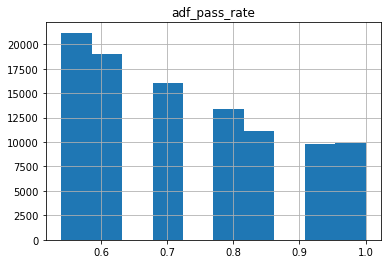

In [67]:
df[['adf_pass_rate']].abs(

In [72]:
df[df['beta'] < 0

,ticker_x,ticker_y,trade_date,adf_pass_rate,last_residual,beta,intercept,residual_mean_max,return_one_month,residual_one_month,return_two_month,residual_two_month,return_three_month,residual_three_month,data_window_start,subindustry,label
227,AYX,MIME,2021-10-06,0.77,2.42,-0.02,46.77,4.02,-0.25,4.498332,-0.18,3.876035,-0.24,4.412475,2017-11-14,software_and_services,0
228,AYX,PRGS,2021-10-06,0.62,2.06,-0.01,40.73,4.02,-0.06,2.708405,0.02,1.839296,0.07,1.347229,2017-11-14,software_and_services,0
293,CTXS,MIME,2021-10-06,0.85,2.44,-0.04,49.52,4.02,-0.25,4.450572,-0.17,3.790526,-0.25,4.428215,2017-11-14,software_and_services,0
320,EPAY,MIME,2021-10-06,0.62,2.37,-0.13,50.79,4.02,-0.28,4.594093,-0.20,3.953448,-0.30,4.708927,2017-11-14,software_and_services,0
1091,DINO,HESM,2021-10-06,0.62,2.04,-0.01,17.84,3.10,0.03,1.845883,0.01,1.976122,-0.11,2.769081,2017-11-14,energy,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100280,CUK,CZR,2021-06-14,0.54,2.60,-0.18,58.53,3.36,0.13,1.963155,0.13,1.935340,0.03,2.457593,2017-07-24,consumer_services,0
100282,CUK,JACK,2021-06-14,0.54,2.36,-0.01,82.11,3.36,0.11,1.539421,0.14,1.284570,0.15,1.192287,2017-07-24,consumer_services,0
100283,CUK,MCRI,2021-06-14,0.62,2.24,-0.02,47.23,3.36,0.10,1.598162,0.05,1.905808,0.09,1.669533,2017-07-24,consumer_services,0
100394,GNW,PRI,2021-06-14,0.54,2.23,-1.42,125.46,3.06,0.08,1.466354,0.05,1.743754,0.06,1.704487,2017-07-24,insurance,0
